# 😀Main Quest 07
<br>  
<br>  
<br>  

## 폐렴을 진단해보자 

이번 퀘스트에서 다루게 될 X-RAY 이미지를 기반으로 하는 폐렴 진단 딥러닝 모델을 제작해 보게 된다. 

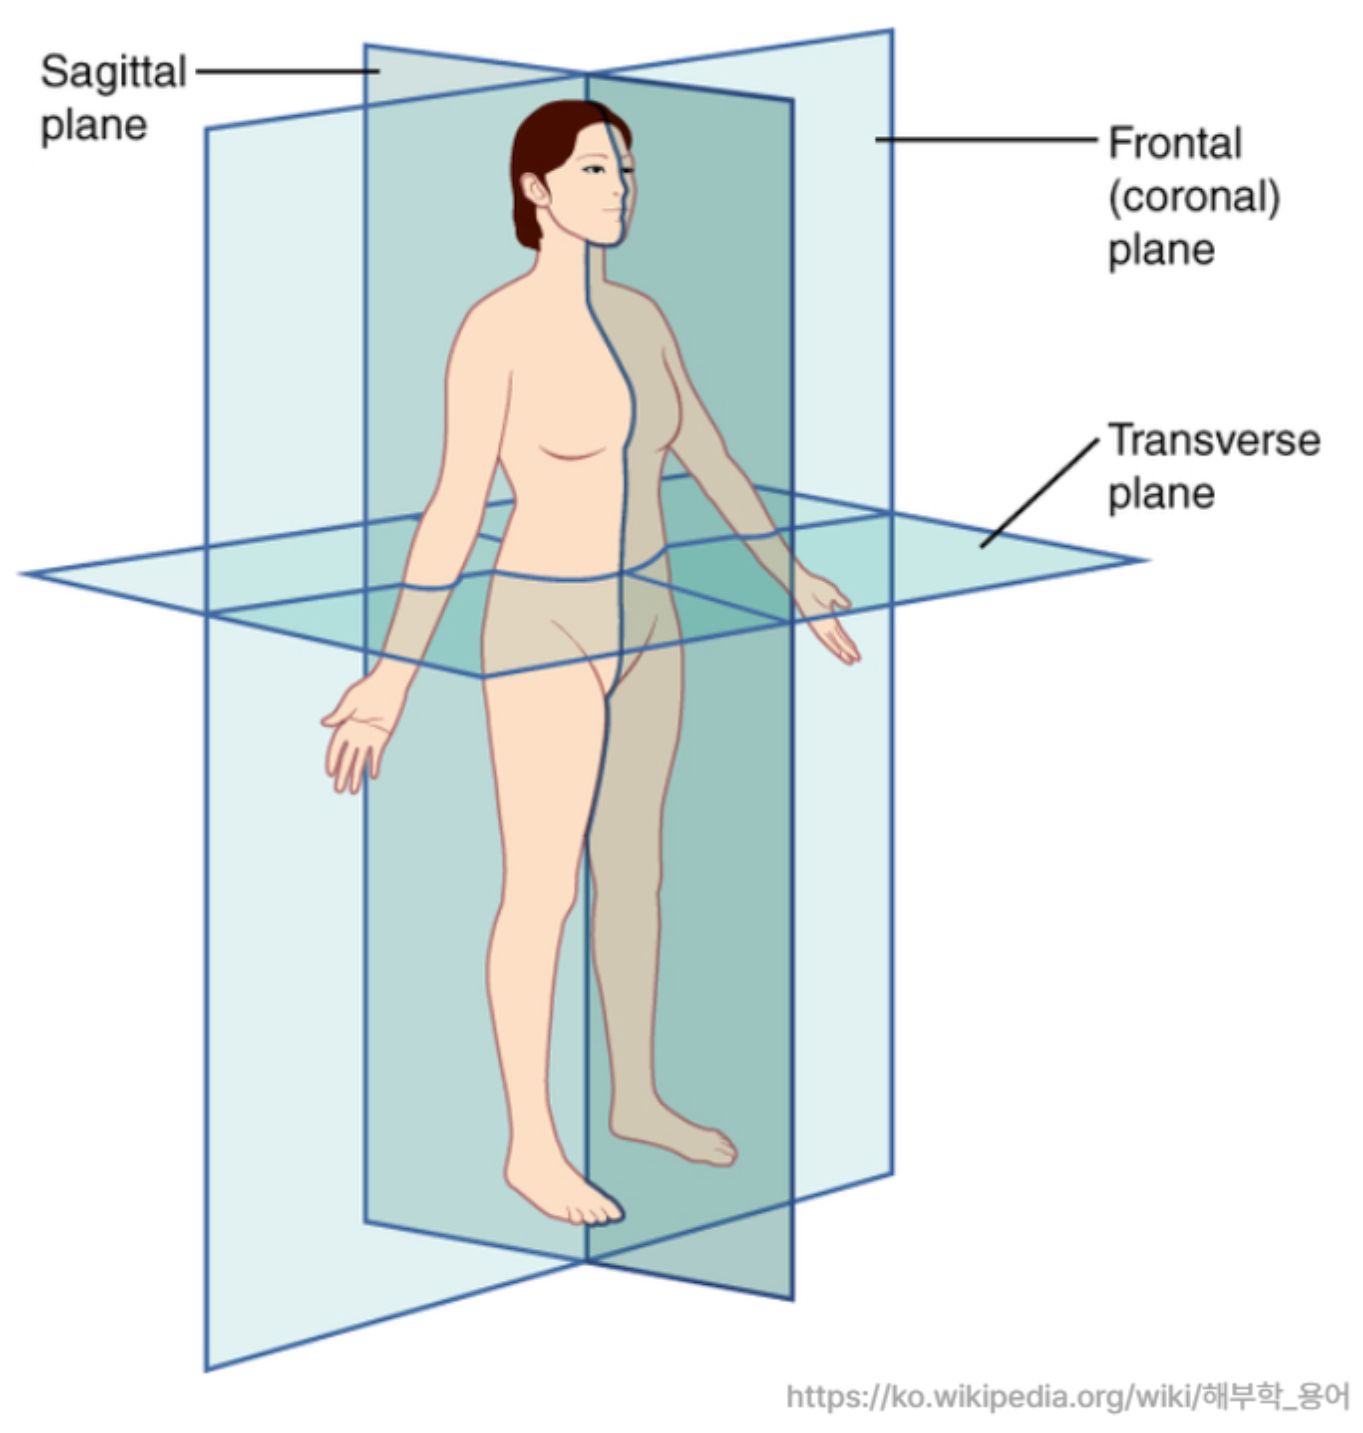  

- **Sagittal plane : 시상면.** 사람을 왼쪽과 오른쪽을 나누는 면.  

- **Coronal plane : 관상면.** 인체를 앞뒤로 나누는 면.  

- **Transverse plane : 횡단면(수평면).** 인체를 상하로 나누는 면.  

<br>  
<br>  

---  

### 폐렴 구별법 
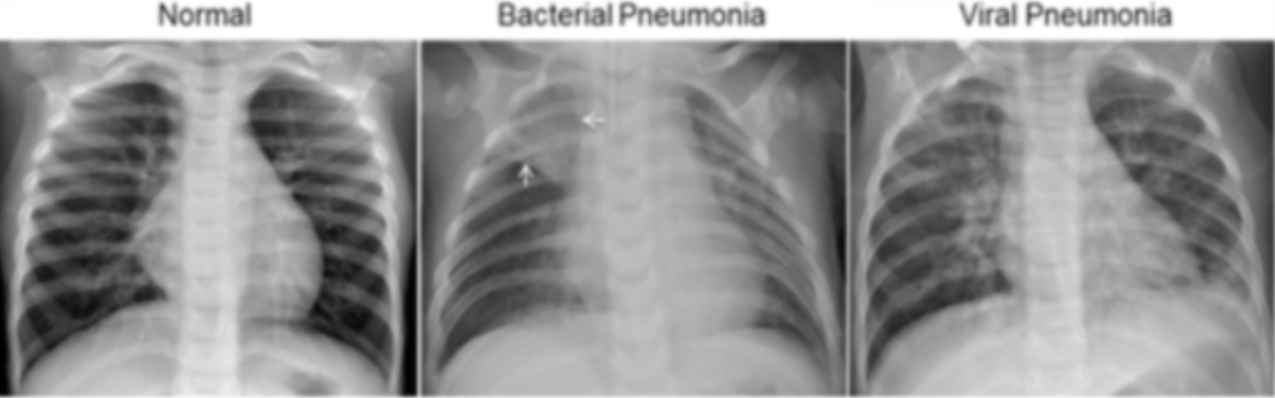  
정상적인 흉부 X-RAY(왼쪽)는 이미지에서 비정상적인 음영 영역이 없는 깨끗한 폐를 보여준다.  
세균성 폐렴 (가운데)은 일반적으로 오른쪽 상부 엽 (흰색 화살표)에 있는 나타내는 반면, 바이러스성 폐렴 (오른쪽)은 양쪽 폐에서보다 확산된 "interstitial(조직 사이에 있는)" 패턴으로 나타난다.  

---

<br>  
<br>  
<br>  

## 모델 구현을 시작해보자!  
resnet 모델을 만들어봄에 있어서 여러 시행착오가 있었다.   
주석처리가 된 코드는 변수명을 수정하지 않고 적다가 사달이 난 것..   
그 후에 제대로 코드를 수정하여 모델을 구현해보았다.

/aiffel/aiffel
5216
624
16
4185
1047
Normal image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person1679_bacteria_4452.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person1345_bacteria_3422.jpeg
Normal images count in training set: 1069
Pneumonia images count in training set: 3116
Training images count: 4185
Validating images count: 1047
Image shape:  (180, 180, 3)
Label:  True
624


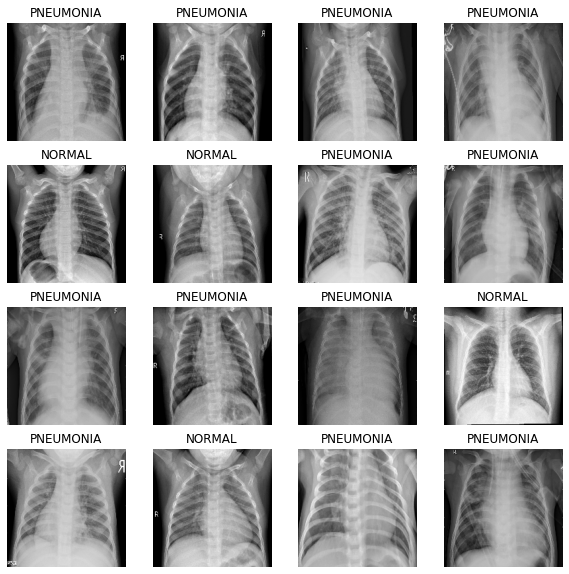

In [10]:
# 라이브러리 불러오기
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 16
EPOCHS = 5

print(ROOT_PATH)

# 데이터 가져오기
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

# val 개수가 너무 없기 때문에 train에서 val에 쓰일 데이터를 더 가져와보자.
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

# 라벨 데이터를 만들어주는 함수
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있다.
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

# 이미지를 알맞은 형식으로 바꾸기.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어오기.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

# test 데이터셋도 만들기
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

#  tf.data 파이프라인을 이용하여 prepare_for_training() 함수를 정의해서 데이터를 변환
def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

# 데이터 시각화
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

plt.show()




In [11]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, MaxPooling2D, GlobalAveragePooling2D, Dense
def residual_block(x, filters, kernel_size=3, stride=1):
    # 첫 번째 convolution layer
    y = Conv2D(filters, kernel_size=kernel_size, strides=stride, padding='same')(x)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)

    # 두 번째 convolution layer
    y = Conv2D(filters, kernel_size=kernel_size, padding='same')(y)
    y = BatchNormalization()(y)

    # Residual connection
    if stride > 1:  # downsampling이 필요한 경우
        x = Conv2D(filters, kernel_size=1, strides=stride, padding='same')(x)
    
    out = Add()([x, y])
    out = Activation('relu')(out)

    return out

def build_model():
    inputs = Input(shape=(180, 180, 3))

    # 첫 번째 convolution layer
    x = Conv2D(64, kernel_size=7, strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

    # Residual blocks
    x = residual_block(x, filters=64, stride=2)
    x = residual_block(x, filters=64, stride=2)
    x = residual_block(x, filters=128, stride=2)
    x = residual_block(x, filters=128, stride=1)
    x = residual_block(x, filters=256, stride=2)
    x = residual_block(x, filters=256, stride=1)
    x = residual_block(x, filters=512, stride=2)
    x = residual_block(x, filters=512, stride=1)

    # Global average pooling
    x = GlobalAveragePooling2D()(x)

    # Fully connected layer
    outputs = Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    return model

def resnet_18(input_shape=(180, 180, 3), num_classes=1):
    inputs = Input(shape=input_shape)

    # 첫 번째 convolution layer
    x = Conv2D(64, kernel_size=7, strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

    # Residual blocks
    x = residual_block(x, filters=64, stride=2)
    x = residual_block(x, filters=64, stride=2)
    x = residual_block(x, filters=128, stride=2)
    x = residual_block(x, filters=128, stride=1)
    x = residual_block(x, filters=256, stride=2)
    x = residual_block(x, filters=256, stride=1)
    x = residual_block(x, filters=512, stride=2)
    x = residual_block(x, filters=512, stride=1)

    # Global average pooling
    x = GlobalAveragePooling2D()(x)

    # Fully connected layer
    outputs = Dense(num_classes, activation='sigmoid')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    return model
'''
# ResNet-18 모델 생성
resnet18_model = resnet_18()

# 모델 컴파일
resnet18_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
'''
model = resnet_18()  # resnet18_model 대신 model로 변수명 변경해보자.
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
# 모델 구조 확인
model.summary()

# 클래스 가중치 조절
weight_for_0 = 1.0  # NORMAL 클래스의 가중치
weight_for_1 = 5.0  # PNEUMONIA 클래스의 가중치

class_weight = {0: weight_for_0, 1: weight_for_1}

# 모델 컴파일 시 class_weight 인자 활용
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
)


Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 180, 180, 3) 0                                            
__________________________________________________________________________________________________
conv2d_110 (Conv2D)             (None, 90, 90, 64)   9472        input_6[0][0]                    
__________________________________________________________________________________________________
batch_normalization_85 (BatchNo (None, 90, 90, 64)   256         conv2d_110[0][0]                 
__________________________________________________________________________________________________
activation_85 (Activation)      (None, 90, 90, 64)   0           batch_normalization_85[0][0]     
____________________________________________________________________________________________

In [ ]:
# 모델 훈련
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

# 결과 확인

fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()


for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])


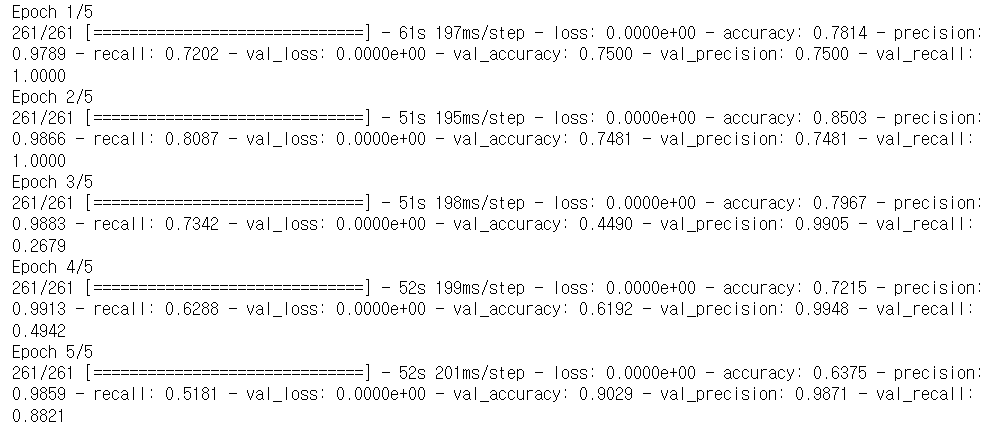

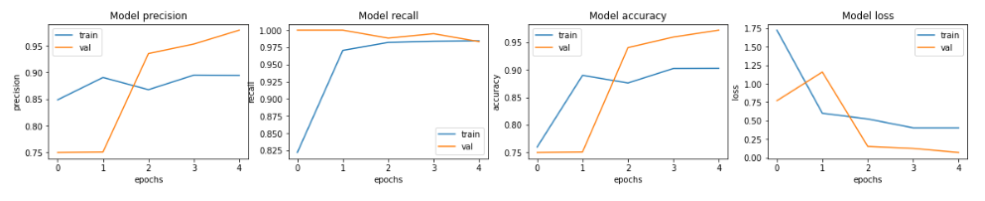

In [ ]:
# 모델 평가
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

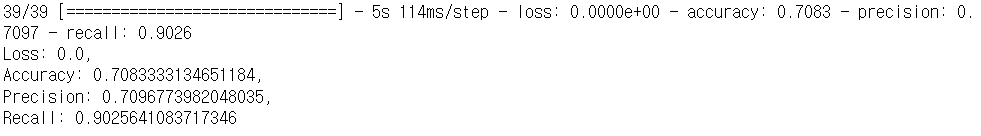

<br>  
<br>  
<br>  

---

## 회고  
<br> 

- **Keep** :  
    막힌 부분에 관하여 계속해서 검색했고 내 머릿속을 스쳐지나갔던 모델링의 기억들을 모아보려 노력했다.  
    
- **Problem** :  
    어떻게 시작해야할지 막막함에 시간을 허비했던 것이 아쉽고, 변수명을 여러개를 지어놓고 헷갈렸던 부분이 굉장히 아쉽다.  
    값이 가장 잘 나왔던 코드를 저장해두었는데 시간이 없어서 사진으로나마 추가한다. 시간이 좀 더 있었으면...!
    
- **Try** :  
    그래도 계속해서 시도했던 점! 학습시간이 오래걸려 시간이 더 많았으면 이런저런 시도를 해보았을 것 같은데 아쉽다.
    